In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA

In [4]:
df = pd.read_csv('default of credit card clients.csv', header = 1)

In [8]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [10]:
df.rename({'default payment next month':'DEFAULT'}, axis = 'columns',inplace = True)

In [ ]:
df.drop('ID' , axis=1, inplace=True)
df.head()

### Identifying missing data
either remove or impute(guess)


In [14]:
df.dtypes #check the datatypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
DEFAULT      int64
dtype: object

In [17]:
df['SEX'].unique()

array([2, 1], dtype=int64)

In [19]:
df['EDUCATION'].unique()

array([2, 1, 3, 5, 4, 6, 0], dtype=int64)

In [21]:
df['MARRIAGE'].unique() #0 is missing data

array([1, 2, 3, 0], dtype=int64)

#### Dealing with missing data

In [23]:
len(df.loc[(df['EDUCATION'] == 0) | (df['MARRIAGE'] == 0)]) #Check number of rows with missing values

68

In [25]:
len(df)

30000

In [28]:
df_no_missing = df.loc[(df['EDUCATION'] != 0) & (df['MARRIAGE'] != 0)]
len(df_no_missing)

29932

In [36]:
print(df_no_missing['EDUCATION'].unique(),df_no_missing['MARRIAGE'].unique())

[2 1 3 5 4 6] [1 2 3]


#### Downsampling the data

In [38]:
len(df_no_missing)

29932

In [41]:
df_no_default = df_no_missing[df_no_missing['DEFAULT'] == 0]
df_default = df_no_missing[df_no_missing['DEFAULT'] == 1]

In [44]:
df_no_default_downsampled = resample(df_no_default,replace=False,n_samples= 1000,random_state=42)
len(df_no_default_downsampled)

1000

In [46]:
df_default_downsampled = resample(df_default,replace=False,n_samples= 1000,random_state=42)
len(df_default_downsampled)

1000

In [49]:
df_downsample = pd.concat([df_no_default_downsampled,df_default_downsampled])
len(df_downsample)

2000

#### Split data to independent and dependent variables

1. Columns of data that we use to make classifications (X)
2. Column of data that we want to predict (y)

The reason we deal with missing data before splitting is that if we remove rows, splitting after ensures that each row in X correctly corresponds with appropriate Y value

In [50]:
X = df_downsample.drop('DEFAULT', axis=1).copy()
X.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
641,130000,2,3,1,28,0,0,0,0,-2,...,50000,0,0,0,2500,1000,0,0,0,0
4678,170000,1,3,1,29,0,0,0,0,0,...,172307,35234,32869,33862,7200,7500,1200,1200,1500,1300
16004,180000,2,2,1,29,0,0,0,0,0,...,26310,26662,26166,26176,1800,1800,1500,1056,950,1000
22974,210000,2,2,2,32,-2,-2,-2,-2,-2,...,410,0,0,0,979,412,0,0,0,0
17535,190000,2,3,1,45,0,0,0,0,0,...,80548,81778,83082,84811,3300,3331,3359,2663,2751,3000


In [51]:
y = df_downsample['DEFAULT'].copy()
y.head()

641      0
4678     0
16004    0
22974    0
17535    0
Name: DEFAULT, dtype: int64

#### One-Hot Encoding
LIMIT_Bal - Integer
SEX - Category(1=male,2=female)
EDUCATION - Category (1=graduate,2=uni,3=high school,4=others)
MARRIAGE - Category (1=Married,2=Single,3=Other)
AGE - Integer
PAY_ - Category (-1=On time,1=Delayed by one month,2=Delayed by two ... 9=Delayed by nine or more)
BILL_AMT - Integer --> Last 6 bills
Pay_AMT - Integer --> Last payments
DEFAULT - Category (0=Did not get defaulted,1=Defaulted)

In [53]:
pd.get_dummies(X,columns=['MARRIAGE']).head()

,LIMIT_BAL,SEX,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
641,130000,2,3,28,0,0,0,0,-2,-2,...,0,2500,1000,0,0,0,0,1,0,0
4678,170000,1,3,29,0,0,0,0,0,0,...,33862,7200,7500,1200,1200,1500,1300,1,0,0
16004,180000,2,2,29,0,0,0,0,0,0,...,26176,1800,1800,1500,1056,950,1000,1,0,0
22974,210000,2,2,32,-2,-2,-2,-2,-2,-2,...,0,979,412,0,0,0,0,0,1,0
17535,190000,2,3,45,0,0,0,0,0,0,...,84811,3300,3331,3359,2663,2751,3000,1,0,0


In [55]:
X_encoded = pd.get_dummies(X,columns=['SEX','EDUCATION','MARRIAGE','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6'])
X_encoded.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,PAY_5_7,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7
641,130000,28,100143,50456,50000,0,0,0,2500,1000,...,0,1,0,0,0,0,0,0,0,0
4678,170000,29,165027,168990,172307,35234,32869,33862,7200,7500,...,0,0,0,1,0,0,0,0,0,0
16004,180000,29,25781,26000,26310,26662,26166,26176,1800,1800,...,0,0,0,1,0,0,0,0,0,0
22974,210000,32,355,975,410,0,0,0,979,412,...,0,1,0,0,0,0,0,0,0,0
17535,190000,45,76433,78472,80548,81778,83082,84811,3300,3331,...,0,0,0,1,0,0,0,0,0,0


#### Centering and Scaling
The RBF that we are using with our SVM assumes that the data are cenered and scaled ie: each column should have a mean value = 0 and a standard deviation = 1. So we need to do this to both the training and testing datasets

We split the data into training and testing sets and then scale them separately to avoid Data Leakage - when info about training dataset influences testing dataset

In [56]:
X_train,X_test,y_train,y_test = train_test_split(X_encoded,y,random_state=42)
X_train_scaled = scale(X_train)
X_test_Scaled = scale(X_test)

#### Building Preliminary SVM

In [61]:
clf_svm = SVC(random_state=42)
clf_svm.fit(X_train_scaled,y_train)

SVC(random_state=42)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


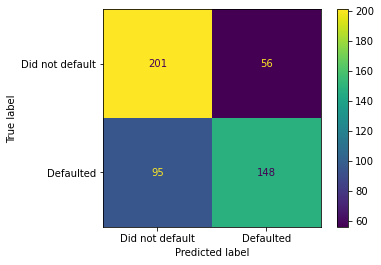

In [62]:
# Drawing confusion matrix
plot_confusion_matrix(clf_svm,X_test_Scaled,y_test,values_format='d',display_labels=["Did not default","Defaulted"])

In the confusion matrix, out of DID NOT DEFAULT 201(79%) correctly classified,
out of DEFAULTED 148(61%) correctly classified.

### Optimize parameters using Cross Validation and GridSearchCV ()
Optimizing is about finding best value for **gamma**, and potentially the regularization parameter **C**.

We use GridSearchCV() to optimize parameters gamma and c. We specify potential values for **gamma** and **C**

In [63]:
param_grid = [{'C':[0.5,1,10,100],'gamma':['scale',1,0.1,0.01,0.001,0.0001],'kernel':['rbf']},]

optimal_params = GridSearchCV(SVC(),param_grid,cv=5,scoring='accuracy',verbose=0)

optimal_params.fit(X_train_scaled,y_train)
print(optimal_params.best_params_)

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


Python has told us that ideal value of C is **100**, which means when we will use regularization, ideal gamma value is **0.001**

#### Build, Evaluate, Draw and interpret final SVM

In [64]:
clf_svm = SVC(random_state=42,C=100,gamma=0.001)
clf_svm.fit(X_train_scaled,y_train)

SVC(C=100, gamma=0.001, random_state=42)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


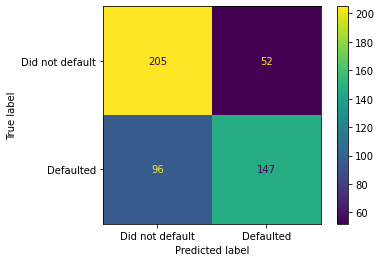

In [65]:
plot_confusion_matrix(clf_svm,X_test_Scaled,y_test,values_format='d',display_labels=["Did not default","Defaulted"])

Now we have to draw the decision boundary and interpret it

In [66]:
len(df_downsample.columns) #tells us number of

24

Here we see that there are 24 features(columns) in X. Thus our graph should be 24 dimensions to plot in raw form which is not possible. So we use PCA(Principal Component Analysis) to combine the 24 to 2.

we can obtain the accuracy of the graph by drawing a "scree plot"

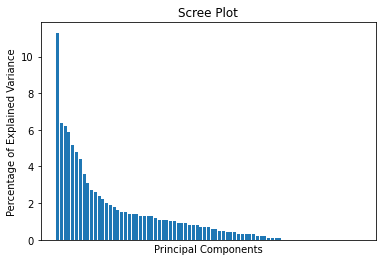

In [69]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_*100,decimals=1)
labels = [str(x) for x in range(1,len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1),height=per_var)
plt.tick_params(
    axis = 'x',         # changes apply to the x-axis
    which = 'both',     # both major and minor ticks are affected
    bottom = False,     # ticks along bottom edge turned off
    top = False,        # ticks along top edge turned off
    labelbottom = False)# labels along bottom edge turned off

plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show()

In [70]:
train_pc1_coords = X_train_pca[:,0]
train_pc2_coords = X_train_pca[:,1]

pca_train_scaled = scale(np.column_stack((train_pc1_coords,train_pc2_coords)))

param_grid = [{'C':[1,10,100,1000],'gamma':['scale',1,0.1,0.01,0.001,0.0001],'kernel':['rbf']},]

optimal_params = GridSearchCV(SVC(),param_grid,cv=5,scoring='accuracy',verbose=0)
optimal_params.fit(pca_train_scaled,y_train)
print(optimal_params.best_params_)

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}


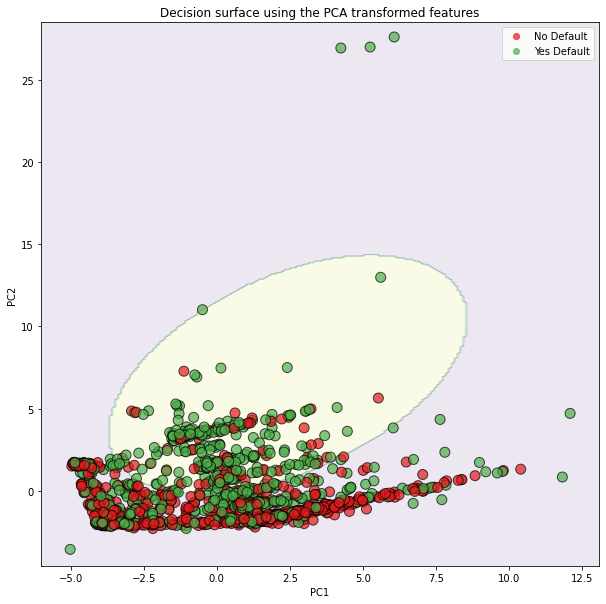

In [75]:
clf_svm = SVC(random_state=42,C=1000,gamma=0.001)
clf_svm.fit(pca_train_scaled,y_train)

## Transform the test dataset with PCA
X_test_pca = pca.transform(X_train_scaled)
test_pc1_coords = X_test_pca[:,0]
test_pc2_coords = X_test_pca[:,1]

x_min = test_pc1_coords.min() - 1
x_max = test_pc1_coords.max() + 1

y_min = test_pc2_coords.min() - 1
y_max = test_pc2_coords.max() + 1

xx, yy = np.meshgrid(np.arange(start=x_min,stop=x_max, step=0.1),
                     np.arange(start = y_min,stop = y_max,step = 0.1))

z = clf_svm.predict(np.column_stack((xx.ravel(),yy.ravel())))
z = z.reshape(xx.shape)

fig, ax = plt.subplots(figsize = (10,10))
ax.contourf(xx,yy,z,alpha = 0.1)

cmap = colors.ListedColormap(['#e41a1c','#4daf4a'])
scatter = ax.scatter(test_pc1_coords,test_pc2_coords, c = y_train,
                     cmap = cmap,
                     s = 100,
                     edgecolors = 'k',
                     alpha = 0.7)

## Creating a legend
legend = ax.legend(scatter.legend_elements()[0],
                   scatter.legend_elements()[1],
                   loc = "upper right")
legend.get_texts()[0].set_text("No Default")
legend.get_texts()[1].set_text("Yes Default")

#add axis labels and titles
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_title("Decision surface using the PCA transformed features")

plt.show()

Pink part of the graph is the area where all datapoints are predicted as  "Not Defaulted". Yellow part is the area where datapoints are predicted to "have defaulted".